# Parallel Workflow

In [170]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [171]:
class BatsmanState(TypedDict):

    runs : int
    balls : int
    fours : int
    sixes: int

    sr : float
    bpb : float
    boundary_percent: float
    summary: str

In [172]:
# Creating the caculate_sr_node function

def caculate_sr_func(state: BatsmanState):

    sr = (state["runs"]/state["balls"])*100

    state['sr'] = sr

    return { "sr" : sr }

In [173]:
# Creating the calculate_bpb_func function

def calculate_bpb_func(state: BatsmanState):

    bpb = state["balls"]/(state["fours"] + state["sixes"])

    state['bpb'] = bpb

    return { "bpb" : bpb }

In [174]:
# Defining calculate_boundary_percent_func function

def calculate_boundary_percent_func(state: BatsmanState):

    boundary_percent = ( ( (state['fours']*4) + (state['sixes']*6) ) / (state['runs']))*100

    state['boundary_percent'] = boundary_percent

    return { "boundary_percent" : boundary_percent }

In [175]:
# Defining summary function 

def summary_func(state: BatsmanState) -> BatsmanState:

    summary = f"""
    Strike Rate - {state["sr"]}
    Balls Per Boundary - {state['bpb']}
    Boundary Percent - {state["boundary_percent"]}
    """

    state['summary'] = summary

    return state

In [176]:
# Creating Graph
batsman_graph = StateGraph(BatsmanState)

# Adding Nodes
batsman_graph.add_node("caculate_sr_node", caculate_sr_func)
batsman_graph.add_node("calculate_bpb__node", calculate_bpb_func)
batsman_graph.add_node("calculate_boundary_percent__node", calculate_boundary_percent_func)
batsman_graph.add_node("summary_node", summary_func)

# Adding Edges
batsman_graph.add_edge(START, "caculate_sr_node")
batsman_graph.add_edge(START, "calculate_bpb__node")
batsman_graph.add_edge(START, "calculate_boundary_percent__node")

batsman_graph.add_edge("caculate_sr_node", "summary_node")
batsman_graph.add_edge("calculate_bpb__node", "summary_node")
batsman_graph.add_edge("calculate_boundary_percent__node", "summary_node")

batsman_graph.add_edge("summary_node", END)

# Compile Graph
workflow = batsman_graph.compile()

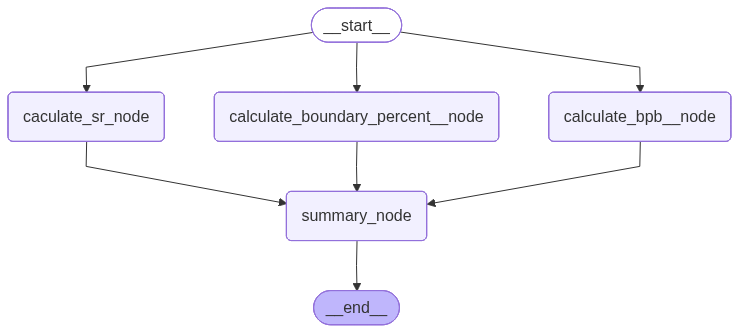

In [177]:
workflow

In [178]:
initial_state = {
    "runs": 150,
    "balls": 50, 
    "fours": 12,
    "sixes": 8
}

final_state = workflow.invoke(initial_state)
final_state

{'runs': 150,
 'balls': 50,
 'fours': 12,
 'sixes': 8,
 'sr': 300.0,
 'bpb': 2.5,
 'boundary_percent': 64.0,
 'summary': '\n    Strike Rate - 300.0\n    Balls Per Boundary - 2.5\n    Boundary Percent - 64.0\n    '}

# LLM Integrated Parallel Workflow

In [179]:
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from typing import TypedDict
from dotenv import load_dotenv
load_dotenv()

True

In [180]:
# Creating the state to be used in blog
class BlogState(TypedDict):

    blog : str
    blog_cot : float
    blog_doa : float
    blog_lang : float
    average_score = float

In [181]:
gpt_model = init_chat_model("gpt-5-nano")
gpt_model

ChatOpenAI(profile={'max_input_tokens': 272000, 'max_output_tokens': 128000, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x7fbeeeb546b0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x7fbeeeb2ef00>, root_client=<openai.OpenAI object at 0x7fbeeeb57ad0>, root_async_client=<openai.AsyncOpenAI object at 0x7fbeeeb565a0>, model_name='gpt-5-nano', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [182]:
# Defining the calculate_cot_func - Function 

def calculate_cot_func(state: BlogState, model = gpt_model):

    # Let's extract the blog content 
    blog = state['blog']
    
    # Let's Create a Prompt to pass to model along with blog
    prompt = f"Your role is to analyse the blog content for Clarity of Thoughts and JUST OUTPUT THE NUMERICAL NUMBER scoring the blog on the scale of 10. Here is the blog = {blog}"

    # now invoking the model to perform this task - This is one that will contribute the latency
    response = model.invoke(prompt)

    # Extracting the content from the response and saving it to BlogState
    blog_cot = response.content

    return { "blog_cot" : blog_cot }

In [183]:
# Defining the calculate_doa_node function

def calculate_doa_func(state: BlogState, model = gpt_model):

    # Let's extract the blog content
    blog = state['blog']

    # Let's create a prompt to pass to model along with blog
    prompt = f"Your role is to analyse the blog content for Depth of Area and JUST OUTPUT THE NUMERICAL NUMBER scoring the blog on the scale of 10. Here is the blog = {blog}"

    # Now invoking the model to perform this task - This is one that will contribute the latency 
    response = model.invoke(prompt)

    # Extracting the content from the response and sacing it to BlogState
    blog_doa= response.content

    return { "blog_doa" : blog_doa }

In [184]:
# Defining the calculate_doa_node function

def calculate_lang_func(state: BlogState, model = gpt_model):

    # Let's extract the blog content
    blog = state['blog']

    # Let's create a prompt to pass to model along with blog
    prompt = f"Your role is to analyse the blog content for Clarity in Language and JUST OUTPUT THE NUMERICAL NUMBER scoring the blog on the scale of 10. Here is the blog = {blog}"

    # Now invoking the model to perform this task - This is one that will contribute the latency 
    response = model.invoke(prompt)

    # Extracting the content from the response and sacing it to BlogState
    blog_lang = response.content

    return { "blog_lang" : blog_lang }

In [185]:
# Defining the average_score function

def average_score_func(state: BlogState):

    blog_cot = float(state['blog_cot'])
    blog_doa = float(state['blog_doa'])
    blog_lang = float(state['blog_lang'])
    
    average_score = (blog_cot + blog_doa +blog_lang)/3

    return { "average_score" : average_score }

In [186]:
# Creating the Graph
blog_graph = StateGraph(BlogState)

# Creating the Nodes
blog_graph.add_node("calculate_cot_node", calculate_cot_func)
blog_graph.add_node("calculate_doa_node", calculate_doa_func)
blog_graph.add_node("calculate_lang_node", calculate_lang_func)
blog_graph.add_node("average_score_node", average_score_func)

# Creating the Edges
blog_graph.add_edge(START, "calculate_cot_node")
blog_graph.add_edge(START, "calculate_doa_node")
blog_graph.add_edge(START, "calculate_lang_node")


blog_graph.add_edge("calculate_cot_node", "average_score_node")
blog_graph.add_edge("calculate_doa_node", "average_score_node")
blog_graph.add_edge("calculate_lang_node", "average_score_node")

blog_graph.add_edge("average_score_node", END)

# Running the Compiler Workflow
workflow = blog_graph.compile()

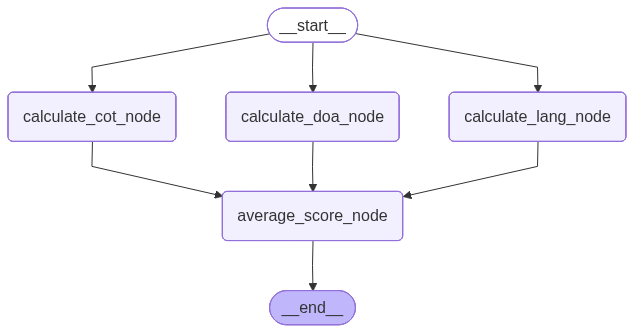

In [187]:
workflow

In [188]:
initial_state = {
    "blog" : """Building a useful quantum computer in practice is incredibly challenging. Significant improvements are needed in the scale, fidelity, speed, reliability, and programmability of quantum computers to fully realize their benefits. Powerful tools are needed to help with the many complex physics and engineering challenges that stand in the way of useful quantum computing. AI is fundamentally transforming the landscape of technology, reshaping industries, and altering how we interact with the digital world. The ability to take data and generate intelligence paves the way for groundbreaking solutions to some of the most challenging problems facing society today. From personalized medicine to autonomous vehicles, AI is at the forefront of a technological revolution that promises to redefine the future, including many challenging problems standing in the way of useful quantum computing. Quantum computers will integrate with conventional supercomputers and accelerate key parts of challenging problems relevant to government, academia, and industry. This relationship is described in An Introduction to Quantum Accelerated Supercomputing. The advantages of integrating quantum computers with supercomputers are reciprocal, and this tight integration will also enable AI to help solve the most important challenges standing in the way of useful quantum computing. This post explores three key aspects of quantum computing that are supported by AI—the processor, error correction, and algorithms. It also explores some practical considerations for building an infrastructure where AI can most effectively enable quantum computing. Improving quantum processors. Quantum processors, or QPUs, are physics and engineering marvels consisting of many fine-tuned systems for protecting and manipulating quantum bits (qubits). Qubits are extremely sensitive and the slightest sources of noise can corrupt a computation. Optimal control is a key aspect of operating a quantum processor and ensures that all necessary operations are performed on the qubits in such a way that minimizes any noise. AI is an important tool for determining optimal control sequences that produce the most quality results possible from a quantum processor.. Foundational work presented in Speedup for Quantum Optimal Control from Automatic Differentiation Based on Graphics Processing Units first demonstrated the utility of GPUs to accelerate automatic differentiation for quantum optimal control. This work resulted in a 19x speedup using a GPU to optimize the preparation of a 10 qubit GHZ state. This led to work presented in Model-Free Quantum Control with Reinforcement Learning, which explores the application of reinforcement learning to quantum optimal control problems.. AI has been applied to many other aspects of quantum device operation such as calibration and qubit readout, demonstrating its utility for reducing noise from multiple sources simultaneously during operation. Correcting errors from noisy qubits. Even the best-engineered quantum hardware processors will exhibit qubit noise levels short of the requirements necessary to run most algorithms. The theoretical solution to this is quantum error correction, a procedure that systematically removes errors from quantum computations and ensures reliable results.  The general steps of a quantum error correction procedure involve encoding quantum information into logical qubits (composed of multiple noisy physical qubits), performing algorithmic operations on the logical qubits, decoding which errors occurred (if any), and correcting the appropriate error. Each step is complex and needs to be executed efficiently so that errors are corrected and the computation completes before any quantum information is lost or otherwise corrupted. Researchers are recognizing that speed, scalability, and an aptitude for complex pattern recognition make AI a fantastic tool for enabling many parts of quantum error correction workflows. For example, a team from the Max Planck Institute and the Friedrich Alexander University in Germany leveraged reinforcement learning to discover new quantum error correction codes and their respective encoders. For details, see Simultaneous Discovery of Quantum Error Correction Codes and Encoders with a Noise-Aware Reinforcement Learning Agent.The decoding step is another promising target for AI, exemplified by Google’s recent work that explores how recurrent, transformer-based neural networks can be used for decoding a standard quantum error correction code known as the surface code. For more information, see Learning to Decode the Surface Code with a Recurrent, Transformer-Based Neural Network."""
}

final_state = workflow.invoke(initial_state)

final_state

{'blog': 'Building a useful quantum computer in practice is incredibly challenging. Significant improvements are needed in the scale, fidelity, speed, reliability, and programmability of quantum computers to fully realize their benefits. Powerful tools are needed to help with the many complex physics and engineering challenges that stand in the way of useful quantum computing. AI is fundamentally transforming the landscape of technology, reshaping industries, and altering how we interact with the digital world. The ability to take data and generate intelligence paves the way for groundbreaking solutions to some of the most challenging problems facing society today. From personalized medicine to autonomous vehicles, AI is at the forefront of a technological revolution that promises to redefine the future, including many challenging problems standing in the way of useful quantum computing. Quantum computers will integrate with conventional supercomputers and accelerate key parts of chall